In [1]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import inspect
import warnings

In [2]:
# ================== 1) Data Loading and Preprocessing ==================

def load_dicom_series(folder_path):
    """
    Load a DICOM series from the specified folder and return a SimpleITK image.
    """
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    """
    Normalize the image to [0,1].
    """
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

In [3]:
# ================== 2) Register PET and CT ==================

def register_pet_ct(ct_image, pet_image, mode="upsample_PET"):
    """
    Register PET image to CT image space.
    mode: Select registration mode, "upsample_PET" to upsample PET to CT space,
          "downsample_CT" to downsample CT to PET space.
    """
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set multi-resolution pyramid strategy
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set registration metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Set transformation type (rigid transformation)
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Set optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                      numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set interpolation method
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Perform registration
    print("\nStarting registration...")
    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32),
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))

        print("\nRegistration completed.")
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final Metric Value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)

    if mode == "upsample_PET":
        resampler.SetReferenceImage(ct_image)
        print("\nResampling PET image to CT space...")
        pet_resampled = resampler.Execute(pet_image)
        print("Resampling completed.")
        return ct_image, pet_resampled

    elif mode == "downsample_CT":
        resampler.SetReferenceImage(pet_image)
        print("\nResampling CT image to PET space...")
        ct_resampled = resampler.Execute(ct_image)
        print("Resampling completed.")
        return ct_resampled, pet_image

    else:
        raise ValueError("Invalid mode selection, mode should be 'upsample_PET' or 'downsample_CT'")

In [28]:
# ================== 3) Sinogram Generation ==================

def generate_sinogram_2d(image_2d, angles):
    """
    Generate a 2D sinogram using Radon transform and ensure that the area outside the circle is zero.
    :param image_2d: 2D NumPy array
    :param angles: List of projection angles (degrees)
    :return: 2D sinogram array
    """
    # Get image dimensions
    rows, cols = image_2d.shape
    # Calculate the radius of the circle
    radius = min(rows, cols) // 2
    # Create a mask to zero out areas outside the circle
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # Generate sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram

def add_poisson_noise(sinogram, scale=1e4):
    """
    Add Poisson noise to a sinogram image.

    :param sinogram: 2D NumPy array representing the sinogram (non-negative).
    :param scale: A scaling factor to simulate photon counts. 
                  Larger scale -> higher counts -> relatively lower noise.
    :return: 2D NumPy array (float) with added Poisson noise.
    """
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    
    return sinogram_noisy

In [5]:
# ================== 4) Kernel Function Design (old)==================

def compute_kernel_2d(ct_2d, sigma=1.0):
    """
    Compute a 2D kernel function based on the CT image, preserving edges using gradient information.
    :param ct_2d: 2D NumPy array
    :param sigma: Standard deviation for Gaussian filtering
    :return: 2D kernel array
    """
    # Compute the gradient of the CT image
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Design a bilateral kernel, assigning lower weights to edges
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

In [88]:
# ================== 4) Kernel Function Design ==================

def psi(u, zeta=0.5, rho=0.01):
    """
    Smooth weighting function as described in the Bowsher-like prior.
    psi(u) = (1/pi) * arctan((zeta - u) / rho) + 0.5
    
    Parameters
    ----------
    u : float or np.ndarray
        The normalized intensity difference.
    zeta : float
        Controls the 'threshold' position in the arctan function.
    rho : float
        Controls the smoothness (slope) in the transition.
    
    Returns
    -------
    float or np.ndarray
        The weight in [0,1] range after applying the arctan-based mapping.
    """
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    """
    A default linear operator Tq, which is the identity mapping in this case.
    
    Parameters
    ----------
    value : float or np.ndarray
        The intensity value(s) to be transformed.
    
    Returns
    -------
    float or np.ndarray
        The same value(s), as we apply the identity transformation.
    """
    return value

In [ ]:
def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):
    """
    Compute 2D Bowsher-like weights (anatomical kernel) for each pixel and its 8 neighbors.
    
    Parameters
    ----------
    ct_image_2d : np.ndarray
        2D array of CT intensities, shape (H, W).
    zeta : float
        Parameter in psi(u), controlling the arctan shift.
    rho : float
        Parameter in psi(u), controlling the smoothness.
    Tq_func : callable
        A function representing the linear operator Tq, default is identity.
        You can replace it with your custom transform if needed.
    epsilon : float
        A small value to avoid division by zero in denominators.
    
    Returns
    -------
    weights_2d : np.ndarray
        A float32 array of shape (H, W, 8). 
        For each pixel (y,x), the last dimension contains the 8 neighbor weights.
    """

    # Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    # We'll store that in an array for quick access
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0

    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) # exp
    #kernel = 1.0 / (1.0 + np.exp(-alpha * kernel)) #sigmoid
    
    return kernel

In [102]:
def compute_bowsher_kernel_3d(
    ct_image_3d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha=0.001
):
    """
    Compute 3D Bowsher-like weights (anatomical kernel) for each voxel and its 26 neighbors.
    
    Parameters
    ----------
    ct_image_3d : np.ndarray
        3D array of CT intensities, shape (D, H, W).
    zeta : float
        Parameter in psi(u), controlling the arctan shift.
    rho : float
        Parameter in psi(u), controlling the smoothness.
    Tq_func : callable
        A function representing the linear operator Tq, default is identity.
    epsilon : float
        A small value to avoid division by zero in denominators.
    
    Returns
    -------
    weights_3d : np.ndarray
        A float32 array of shape (D, H, W, 26). 
        For each voxel (z,y,x), the last dimension contains the 26 neighbor weights.
    """

    # Offsets for the 26 neighbors
    neighbor_offsets_3d = []
    for dz in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dz == 0 and dy == 0 and dx == 0:
                    continue
                neighbor_offsets_3d.append((dz, dy, dx))

    D, H, W = ct_image_3d.shape
    weights_3d = np.zeros((D, H, W, len(neighbor_offsets_3d)), dtype=np.float32)

    # Pre-transform the entire volume
    transformed_ct = Tq_func(ct_image_3d)

    # Compute M_j for each voxel
    M_array = np.zeros((D, H, W), dtype=np.float32)

    for z in range(D):
        for y in range(H):
            for x in range(W):
                central_val = transformed_ct[z, y, x]
                diffs = []
                for dz, dy, dx in neighbor_offsets_3d:
                    nz, ny, nx = z + dz, y + dy, x + dx
                    if 0 <= nz < D and 0 <= ny < H and 0 <= nx < W:
                        neighbor_val = transformed_ct[nz, ny, nx]
                        diffs.append(abs(central_val - neighbor_val))
                if len(diffs) > 0:
                    M_array[z, y, x] = max(diffs)
                else:
                    M_array[z, y, x] = 0.0

    # Compute the local weights
    for z in range(D):
        for y in range(H):
            for x in range(W):
                central_val = transformed_ct[z, y, x]
                Mj = M_array[z, y, x]

                for n_idx, (dz, dy, dx) in enumerate(neighbor_offsets_3d):
                    nz, ny, nx = z + dz, y + dy, x + dx
                    if not (0 <= nz < D and 0 <= ny < H and 0 <= nx < W):
                        # Out of range
                        weights_3d[z, y, x, n_idx] = 0.0
                        continue

                    neighbor_val = transformed_ct[nz, ny, nx]
                    Mk = M_array[nz, ny, nx]

                    denom = (Mj + Mk) / 2.0
                    denom = denom if denom > epsilon else epsilon

                    diff = abs(central_val - neighbor_val)
                    u_jk = diff / denom

                    w_jk = psi(u_jk, zeta=zeta, rho=rho)
                    weights_3d[z, y, x, n_idx] = w_jk

    kernel = np.sum(weights_3d, axis=-1)
    kernel = np.exp(alpha * kernel) # exp
    #kernel = 1.0 / (1.0 + np.exp(-alpha * kernel)) #sigmoid

    return kernel

In [103]:
# ================== 5) KEM Reconstruction Implementation ==================

def KEM_reconstruction_2d(pet_sinogram, ct_kernel, angles, iterations=10):
    """
    Implement a simplified 2D KEM reconstruction algorithm.
    :param pet_sinogram: 2D sinogram
    :param ct_kernel: 2D kernel function
    :param angles: List of projection angles (degrees)
    :param iterations: Number of iterations
    :return: Reconstructed 2D PET image
    """
    # Initialize the image to all ones
    image_shape = ct_kernel.shape
    image = np.ones(image_shape, dtype=np.float32)

    # Small constant to avoid division by zero
    epsilon = 1e-8

    for it in range(iterations):
        # E-Step: Forward projection
        projection = radon(image, theta=angles, circle=True)

        # Compute the ratio
        ratio = pet_sinogram / (projection + epsilon)

        # Back-projection
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # M-Step: Update the image using the kernel function
        image *= back_projection * ct_kernel

        # Regularization to ensure non-negative image
        image = np.maximum(image, 0)

        print(f"Iteration {it+1} completed.")
        #print(f"Iteration {it+1}, image min={image.min()}, image max={image.max()}")

    return image

Loading CT image...
Loading PET image...

CT Image Information:
  Size: (512, 512, 307)
  Spacing: (0.9765625, 0.9765625, 2.5)
  Origin: (-249.51172, -460.51172, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

PET Image Information:
  Size: (128, 128, 307)
  Spacing: (5.3067274, 5.3067274, 2.5)
  Origin: (-339.16485, -553.64165, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

Starting registration...

Registration completed.
Optimizer Converged: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 16.
Final Metric Value: -0.3532775450233479

Resampling CT image to PET space...
Resampling completed.
Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
Iteration 4 completed.
Iteration 5 completed.
Iteration 6 completed.
Iteration 7 completed.
Iteration 8 completed.
Iteration 9 completed.
Iteration 10 completed.
Iteration 11 completed.
Iteration 12 completed.
Iteration 13 complet

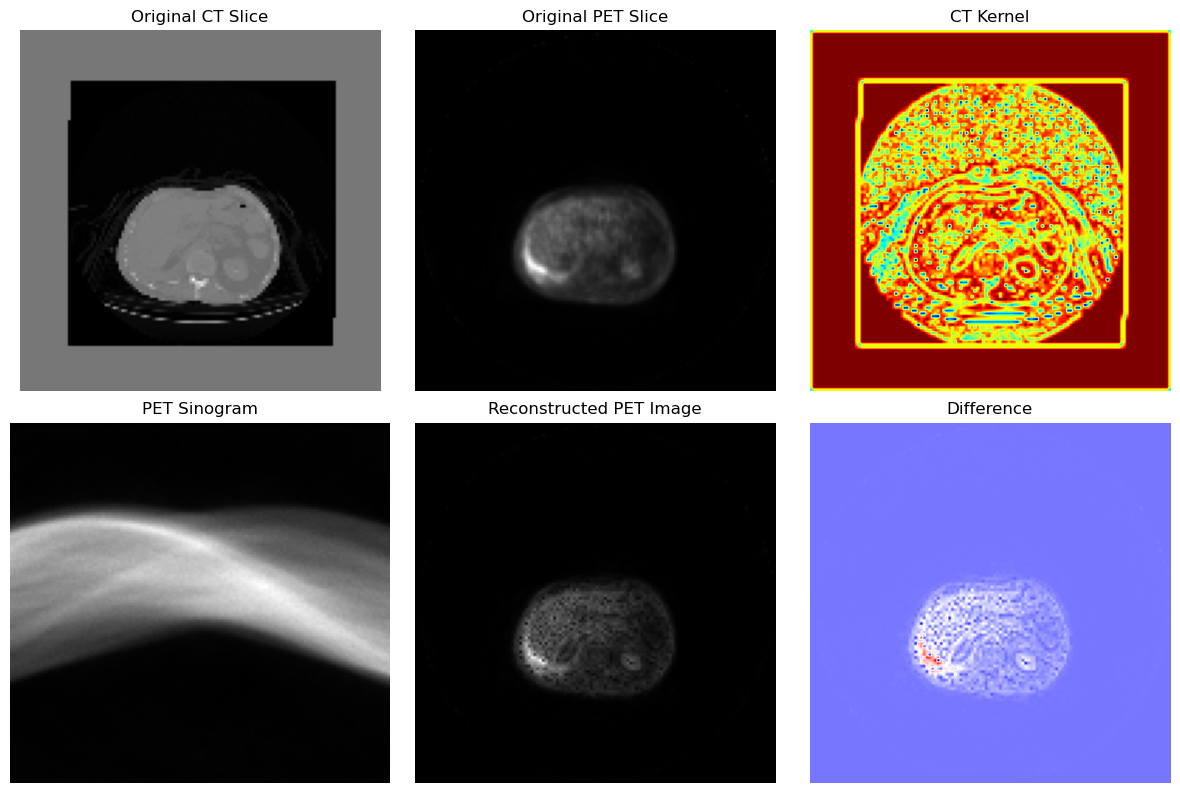

In [104]:
# ================== 6) Main Program ==================

# ================== 1) Load CT and PET Images ==================

ct_folder_path = r"D:\NIH\PET-CT\acrin_nsclc_fdg_pet\ACRIN-NSCLC-FDG-PET-001\1.3.6.1.4.1.14519.5.2.1.7009.2403.156046015078185438233607422806\CT_1.3.6.1.4.1.14519.5.2.1.7009.2403.192241118078441962132923230489"
pet_folder_path = r"D:\NIH\PET-CT\acrin_nsclc_fdg_pet\ACRIN-NSCLC-FDG-PET-001\1.3.6.1.4.1.14519.5.2.1.7009.2403.156046015078185438233607422806\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.121694709831221676480030303736"

# Load images
print("Loading CT image...")
ct_image = load_dicom_series(ct_folder_path)
print("Loading PET image...")
pet_image = load_dicom_series(pet_folder_path)

# Print image information
def print_image_info(name, image):
    print(f"\n{name} Image Information:")
    print(f"  Size: {image.GetSize()}")
    print(f"  Spacing: {image.GetSpacing()}")
    print(f"  Origin: {image.GetOrigin()}")
    print(f"  Direction: {image.GetDirection()}")
    print(f"  Dimension: {image.GetDimension()}")

print_image_info("CT", ct_image)
print_image_info("PET", pet_image)

# Ensure both are 3D images
if ct_image.GetDimension() != 3 or pet_image.GetDimension() != 3:
    raise ValueError("Both CT and PET images must be 3D.")

# Ensure both are float32
ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
pet_image = sitk.Cast(pet_image, sitk.sitkFloat32)

# ================== 2) Register PET to CT ==================

# Select the way to register PET and CT

#mode = "upsample_PET"
mode = "downsample_CT"
ct_image_resampled, pet_image_resampled = register_pet_ct(ct_image, pet_image, mode=mode)

# ================== 3) Select Middle Slice and Generate Sinogram ==================

# Select middle slice
ct_array = sitk.GetArrayFromImage(ct_image_resampled)  # shape: [slices, height, width]
pet_array = sitk.GetArrayFromImage(pet_image_resampled)  # shape: [slices, height, width]

middle_slice_idx = ct_array.shape[0] // 2
ct_slice = ct_array[middle_slice_idx, :, :]
pet_slice = pet_array[middle_slice_idx, :, :]

# Normalize
ct_norm = normalize_image(ct_image_resampled)
pet_norm = normalize_image(pet_image_resampled)
ct_slice_norm = ct_norm[middle_slice_idx, :, :]
pet_slice_norm = pet_norm[middle_slice_idx, :, :]

# Generate sinogram
angles = np.linspace(0., 180., max(ct_slice.shape), endpoint=False)
pet_sinogram = generate_sinogram_2d(pet_slice_norm, angles)
pet_sinogram = add_poisson_noise(pet_sinogram, scale=1e3)

# ================== 4) Design Kernel Function ==================

#ct_kernel = compute_kernel_2d(ct_slice_norm, sigma=1.0)

# 2D kernel
#ct_kernel = compute_bowsher_kernel_2d(ct_slice_norm)

# 3D kernel
ct_kernel = compute_bowsher_kernel_3d(ct_norm)
ct_kernel = ct_kernel[middle_slice_idx, :, :]

# ================== 5) KEM Reconstruction ==================

iterations = 100
pet_reconstructed = KEM_reconstruction_2d(pet_sinogram, ct_kernel, angles, iterations=iterations)

# ================== 6) Visualize Results ==================

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Original CT Slice")
plt.imshow(ct_slice_norm, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Original PET Slice")
plt.imshow(pet_slice_norm, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("CT Kernel")
plt.imshow(ct_kernel, cmap='jet')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("PET Sinogram")
plt.imshow(pet_sinogram, cmap='gray', aspect='auto')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Reconstructed PET Image")
plt.imshow(pet_reconstructed, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Difference")
difference = pet_reconstructed - pet_slice_norm
plt.imshow(difference, cmap='bwr')
plt.axis('off')

plt.tight_layout()
plt.show()

In [105]:
print(ct_kernel.max())
print(ct_kernel.min())

1.0261711
1.0012378
